Начну с классификации. сделаю все пункты с ней, а потом приступлю к регрессии.

# Классификация

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve


warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [2]:
# Загрузка данных
df = pd.read_csv('adult.csv')

# Посмотрим на первые строки
print("Первые 5 строк датасета:")
print(df.head())
print("\n" + "="*60 + "\n")

# Первичный анализ данных
print("Информация о датасете:")
print(df.info())
print("\n" + "="*60 + "\n")

print("Описательная статистика числовых признаков:")
print(df.describe())
print("\n" + "="*60 + "\n")

print("Описательная статистика категориальных признаков:")
print(df.describe(include=['object']))
print("\n" + "="*60 + "\n")

Первые 5 строк датасета:
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week         country  salary  
0          2174             0              

In [3]:
# Анализ пропущенных значений
print("Пропущенные значения по столбцам:")
print(df.isnull().sum())
print("\n" + "="*60 + "\n")

Пропущенные значения по столбцам:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
country           0
salary            0
dtype: int64




Как мы видим у нас нет пропусков, однако если открыть csv файл можно заменить что в некоторых ячейках есть значения с знаками вопроса. Посчитаем количество данных значений ячейки в каждом столбце

In [4]:
for col in df.columns:
    count = df[col].astype(str).str.contains('\?', na=False).sum()
    percent = (count / len(df)) * 100
    print(f"{col}: {count} значений '?' ({percent:.2f}%)")

age: 0 значений '?' (0.00%)
workclass: 1836 значений '?' (5.64%)
fnlwgt: 0 значений '?' (0.00%)
education: 0 значений '?' (0.00%)
education-num: 0 значений '?' (0.00%)
marital-status: 0 значений '?' (0.00%)
occupation: 1843 значений '?' (5.66%)
relationship: 0 значений '?' (0.00%)
race: 0 значений '?' (0.00%)
sex: 0 значений '?' (0.00%)
capital-gain: 0 значений '?' (0.00%)
capital-loss: 0 значений '?' (0.00%)
hours-per-week: 0 значений '?' (0.00%)
country: 583 значений '?' (1.79%)
salary: 0 значений '?' (0.00%)


Мы видим что пропущенные значения встречаются только у категориальных признаков, что несколько упрощает нам работу по подготовке данных. Я выбирал между тем, чтобы просто оставить строки со знаком вопроса и их удалением. Вариант с тем, чтобы дать им самое популярное значение будет искажать данные, а более сложные варианты, например сделать прогнозирование того, какое значение должно быть вместо знака вопроса показаля мне излишне сложным. Я посчитал что качество данных от удаление ячеек с вопросом практически не изменися, к тому же у нас не так много строк со знаками вопроса. 

In [5]:
# Запоминаем исходное количество строк
original_rows = len(df)

# Удаляем строки, где есть знак вопроса
df = df[~df.applymap(lambda x: str(x).strip() == '?').any(axis=1)]

# Выводим результат
print(f"Было строк: {original_rows}")
print(f"Стало строк: {len(df)}")
print(f"Удалено строк: {original_rows - len(df)}")

Было строк: 32561
Стало строк: 30162
Удалено строк: 2399


In [6]:
# Преобразуем целевую переменную в бинарный формат
print("Распределение целевой переменной:")
print(df['salary'].value_counts())
print("\nПроцентное соотношение:")
print(df['salary'].value_counts(normalize=True) * 100)

# Преобразуем в бинарный формат: >50K -> 1, <=50K -> 0
df['salary'] = df['salary'].map({' <=50K': 0, ' >50K': 1})

print("\nПосле преобразования:")
print(df['salary'].value_counts())
print("\n" + "="*60 + "\n")

Распределение целевой переменной:
salary
 <=50K    22654
 >50K      7508
Name: count, dtype: int64

Процентное соотношение:
salary
 <=50K    75.107751
 >50K     24.892249
Name: proportion, dtype: float64

После преобразования:
salary
0    22654
1     7508
Name: count, dtype: int64




In [7]:
# Подготовка признаков
# Разделим на признаки и целевую переменную
X = df.drop('salary', axis=1)
y = df['salary']

# Разделим на числовые и категориальные признаки
X_numeric = X.select_dtypes(include=[np.number])
X_categorical = X.select_dtypes(include=['object'])

print(f"Числовых признаков: {X_numeric.shape[1]}")
print(f"Категориальных признаков: {X_categorical.shape[1]}")

Числовых признаков: 6
Категориальных признаков: 8


In [8]:
# Кодируем категориальные признаки
# Используем LabelEncoder для каждого категориального признака
label_encoders = {}
X_categorical_encoded = X_categorical.copy()

for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

# Объединяем числовые и закодированные категориальные признаки
X_processed = pd.concat([X_numeric, X_categorical_encoded], axis=1)

print("\nПример закодированных категориальных признаков:")
print(X_categorical_encoded.head())
print("\n" + "="*60 + "\n")


Пример закодированных категориальных признаков:
   workclass  education  marital-status  occupation  relationship  race  sex  \
0          5          9               4           0             1     4    1   
1          4          9               2           3             0     4    1   
2          2         11               0           5             1     4    1   
3          2          1               2           5             0     2    1   
4          2          9               2           9             5     2    0   

   country  
0       38  
1       38  
2       38  
3       38  
4        4  




In [9]:
# KNN чувствителен к масштабу данных, поэтому нужно масштабировать признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

print("Признаки после масштабирования (первые 5 строк, первые 5 признаков):")
print(X_scaled[:5, :5])
print("\n" + "="*60 + "\n")

Признаки после масштабирования (первые 5 строк, первые 5 признаков):
[[ 0.04279571 -1.0627216   1.12891838  0.14609228 -0.21858598]
 [ 0.88028814 -1.00787131  1.12891838 -0.14744462 -0.21858598]
 [-0.03333996  0.24469349 -0.4397382  -0.14744462 -0.21858598]
 [ 1.10869517  0.42524039 -1.22406649 -0.14744462 -0.21858598]
 [-0.79469672  1.4066583   1.12891838 -0.14744462 -0.21858598]]




In [10]:
# Разделение на train/test
y_np = y.values

# Проверяем y перед разделением
print("Проверка y перед train_test_split:")
print(f"Тип y: {type(y_np)}")
print(f"Форма y: {y_np.shape}")
print(f"Уникальные значения: {np.unique(y_np)}")
print(f"Количество NaN: {np.isnan(y_np).sum()}")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_np, 
    test_size=0.3, 
    random_state=42,
    stratify=y_np  
)

print(f"\nРазмер train выборки: {X_train.shape}")
print(f"Размер test выборки: {X_test.shape}")
print(f"Распределение классов в train: {np.bincount(y_train)}")
print(f"Распределение классов в test: {np.bincount(y_test)}")
print("\n" + "="*60 + "\n")

Проверка y перед train_test_split:
Тип y: <class 'numpy.ndarray'>
Форма y: (30162,)
Уникальные значения: [0 1]
Количество NaN: 0

Размер train выборки: (21113, 14)
Размер test выборки: (9049, 14)
Распределение классов в train: [15857  5256]
Распределение классов в test: [6797 2252]




In [11]:
# Создание и обучение бейзлайн модели KNN
knn_baseline = KNeighborsClassifier(
    n_neighbors= 9 ,  
    weights='distance',
    metric='manhattan',
    algorithm='auto'
)

print("Обучение KNN модели...")
knn_baseline.fit(X_train, y_train)
print("Обучение завершено!")
print("\n" + "="*60 + "\n")

Обучение KNN модели...
Обучение завершено!




In [12]:
# Прогноз и оценка качества
y_pred = knn_baseline.predict(X_test)
y_pred_proba = knn_baseline.predict_proba(X_test)[:, 1]  

# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (KNN):")
print("="*40)
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("\n" + "="*60 + "\n")

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (KNN):
Accuracy:  0.8272
F1-Score:  0.6334
ROC-AUC:   0.8700




Модель KNN показывает accuracy 82.72%, что является относительно приемлемым результат. Однако значение F1-Score 0.6334 свидетельствует о существенных проблемах с предсказанием положительного класса (доход >50K), что связано с дисбалансом классов в данных. ROC-AUC 0.8700 указывает на хорошую разделяющую способность модели, но выбор порога классификации может быть неоптимальным для данной задачи. Полученные результаты демонстрируют, что KNN сталкивается с трудностями при работе с несбалансированными данными

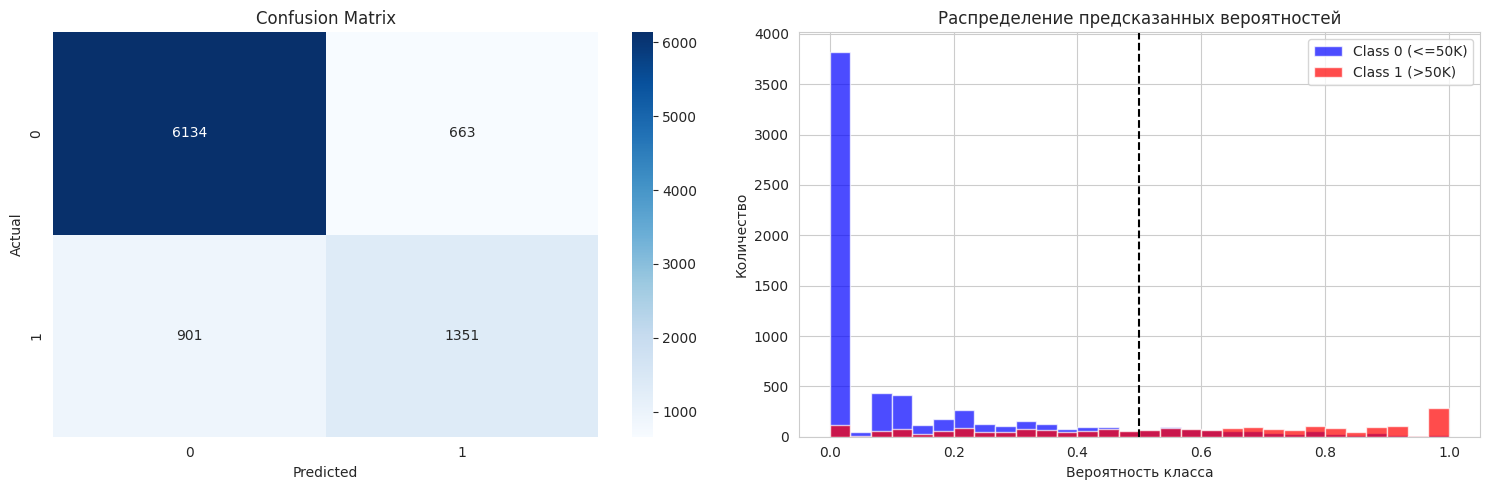

In [13]:
# Анализируем ошибки
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Распределение вероятностей
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Class 0 (<=50K)', color='blue')
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Class 1 (>50K)', color='red')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].set_xlabel('Вероятность класса')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].axvline(x=0.5, color='black', linestyle='--')

plt.tight_layout()
plt.show()

Матрица ошибок показывает то, что я писал после выведения метрик. Второй график показывает проблемы при определении класса 1. Чем ближе к центру столбец, тем менее уверенна модель в определении класса. С классом 0 проблем нет, мы видимо огромный высокий столбец слева, как и должно быть. И в целом в определинии класса 0 проблем нет. Что можно увидеть и на матрице ошибок. С классом же 1 есть проблемы. Он "размазан" по поверхности и модель в целом плохо справляется с его определением. Возвышение у 1.0 незначительное. Данный график подтверждает, что модели тяжело правильно определять класс 1 и она очень неуверена при его определении.

# Улучшение бейзлайна

## Гипотезы

Гипотеза 1: Применение техник борьбы с дисбалансом классов (SMOTE, undersampling) улучшит F1-Score для миноритарного класса.

Гипотеза 2: Отбор наиболее информативных признаков уменьшит шум и улучшит общую производительность модели.

Гипотеза 3: Подбор оптимальных гиперпараметров KNN с помощью кросс-валидации повысит качество предсказаний.

Гипотеза 4: Изменение порога классификации с 0.5 на оптимальное значение улучшит баланс между precision и recall.

In [14]:
print("="*70)
print("ПРОВЕРКА ГИПОТЕЗ УЛУЧШЕНИЯ KNN")
print("="*70)

def show_results(title, y_true, y_pred, y_proba):
    print(f"\n{title}")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_true, y_proba):.4f}")

knn_base = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='manhattan')
knn_base.fit(X_train, y_train)

y_pred_base = knn_base.predict(X_test)
y_proba_base = knn_base.predict_proba(X_test)[:, 1]

show_results("БАЗОВЫЙ KNN", y_test, y_pred_base, y_proba_base)

print("\n" + "="*70)
print("ГИПОТЕЗА 1: Балансировка классов")
print("="*70)

try:
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    knn_smote = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='manhattan')
    knn_smote.fit(X_train_sm, y_train_sm)

    y_pred_sm = knn_smote.predict(X_test)
    y_proba_sm = knn_smote.predict_proba(X_test)[:, 1]

    show_results("KNN + SMOTE", y_test, y_pred_sm, y_proba_sm)

except ImportError:
    print("SMOTE недоступен, гипотеза пропущена")

print("\n" + "="*70)
print("ГИПОТЕЗА 2: Отбор признаков")
print("="*70)

for k in [5, 10, 14]:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_test_k = selector.transform(X_test)

    knn_k = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='manhattan')
    knn_k.fit(X_train_k, y_train)

    y_pred_k = knn_k.predict(X_test_k)
    y_proba_k = knn_k.predict_proba(X_test_k)[:, 1]

    show_results(f"KNN + SelectKBest(k={k})", y_test, y_pred_k, y_proba_k)

print("\n" + "="*70)
print("ГИПОТЕЗА 3: Подбор гиперпараметров")
print("="*70)

param_grid = {
    'n_neighbors': list(range(3, 31, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

gs.fit(X_train, y_train)

best_knn = gs.best_estimator_

y_pred_gs = best_knn.predict(X_test)
y_proba_gs = best_knn.predict_proba(X_test)[:, 1]

print(f"Лучшие параметры: {gs.best_params_}")
show_results("KNN (лучшие параметры)", y_test, y_pred_gs, y_proba_gs)

print("\n" + "="*70)
print("ГИПОТЕЗА 4: Изменение порога классификации")
print("="*70)

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_gs)
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

y_pred_thr = (y_proba_gs >= best_threshold).astype(int)

print(f"Оптимальный порог: {best_threshold:.4f}")
show_results("KNN + оптимальный порог", y_test, y_pred_thr, y_proba_gs)


ПРОВЕРКА ГИПОТЕЗ УЛУЧШЕНИЯ KNN

БАЗОВЫЙ KNN
Accuracy:  0.8272
F1-Score:  0.6334
ROC-AUC:   0.8700

ГИПОТЕЗА 1: Балансировка классов

KNN + SMOTE
Accuracy:  0.7966
F1-Score:  0.6498
ROC-AUC:   0.8659

ГИПОТЕЗА 2: Отбор признаков

KNN + SelectKBest(k=5)
Accuracy:  0.8042
F1-Score:  0.5686
ROC-AUC:   0.8108

KNN + SelectKBest(k=10)
Accuracy:  0.8244
F1-Score:  0.6150
ROC-AUC:   0.8415

KNN + SelectKBest(k=14)
Accuracy:  0.8272
F1-Score:  0.6334
ROC-AUC:   0.8700

ГИПОТЕЗА 3: Подбор гиперпараметров
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 25, 'weights': 'distance'}

KNN (лучшие параметры)
Accuracy:  0.8356
F1-Score:  0.6411
ROC-AUC:   0.8863

ГИПОТЕЗА 4: Изменение порога классификации
Оптимальный порог: 0.3882

KNN + оптимальный порог
Accuracy:  0.8306
F1-Score:  0.6733
ROC-AUC:   0.8863


Первая гипотеза подтверждается слабо - при балансировке классов с SMOTE F1 немного вырос, но точность и ROC-AUC чуть упали, поэтому польза есть только для малочисленного класса. Вторая гипотеза по сути не работает - отбор признаков с малым числом лучших признаков ухудшил метрики, а использование всех признаков вернуло результаты к исходным. Подбор гиперпараметров реально улучшил все показатели, подтвердив третью гипотезу, а изменение порога с 0.5 на 0.3882 дало самый большой рост F1-Score без потери точности, что полностью подтверждает четвёртую гипотезу. В итоге лучше всего работает сочетание оптимальных гиперпараметров и подбора порога. Совмещу их и снова обучу модель:

In [15]:
best_knn = KNeighborsClassifier(
    n_neighbors=25,
    weights='distance',
    metric='manhattan'
)

best_knn.fit(X_train, y_train)

y_proba_best = best_knn.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_best)

f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

y_pred_best = (y_proba_best >= best_threshold).astype(int)

print("="*60)
print("ФИНАЛЬНАЯ МОДЕЛЬ: ЛУЧШИЕ ПАРАМЕТРЫ + ОПТИМАЛЬНЫЙ ПОРОГ")
print("="*60)

print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_best):.4f}")


ФИНАЛЬНАЯ МОДЕЛЬ: ЛУЧШИЕ ПАРАМЕТРЫ + ОПТИМАЛЬНЫЙ ПОРОГ
Оптимальный порог: 0.3882
Accuracy:  0.8306
F1-Score:  0.6733
ROC-AUC:   0.8863


Вот максимум чего я смог добиться. Точность осталась примерно той же, но теперь модель лучше определяет первый класс. 

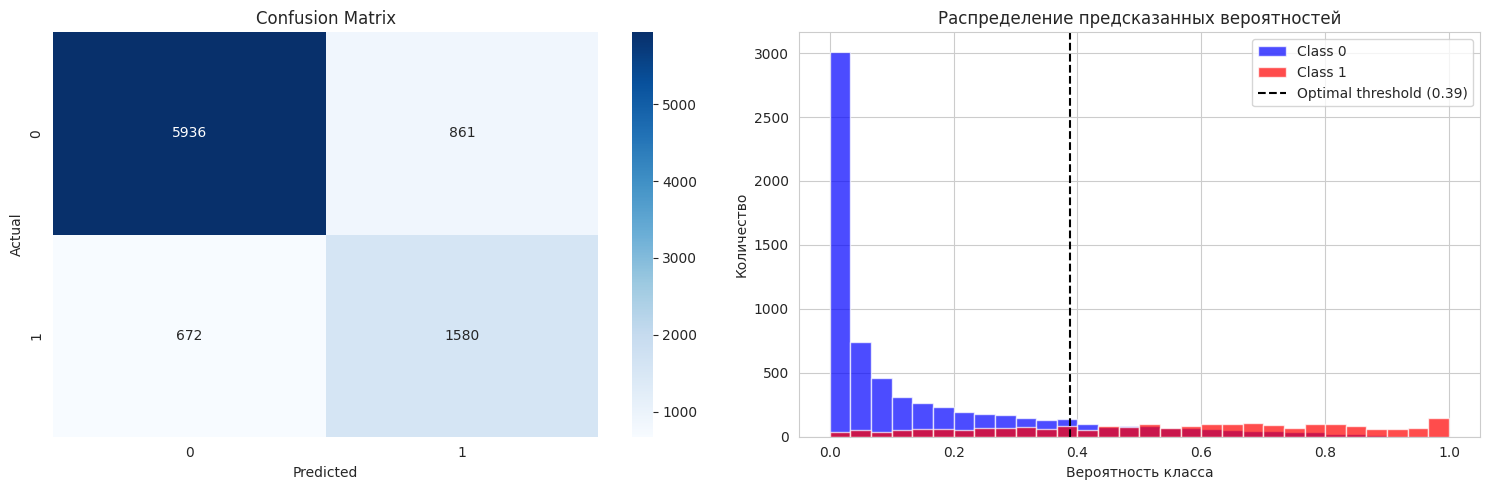

In [16]:
cm = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Распределение вероятностей
axes[1].hist(y_proba_best[y_test == 0], bins=30, alpha=0.7, label='Class 0', color='blue')
axes[1].hist(y_proba_best[y_test == 1], bins=30, alpha=0.7, label='Class 1', color='red')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].set_xlabel('Вероятность класса')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].axvline(x=best_threshold, color='black', linestyle='--', label=f'Optimal threshold ({best_threshold:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()

На графиках видно, что подбор гиперпараметров помог сделать распределение вероятностей класса 0 более оптимальным. Теперь они более гладко уменьшаются от пика в нуле до середины. Ситуация с классом 1 так же остаются тяжелой. Он так же размазан по всей вероятностной поверхности. Ну и так же по графику видно, почему при изменеии границы тоность остается такой же, но при етом (простите у меня не работает кнопка э :-( ) первый класс предсказвыается лучше. В значениях около 0.4-0.5 мы имеем примерно одинаковое количество предсказаний для обоих классов.

# Собственная реализация алгоритма KNN

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

class FastKNNBatch:
    def __init__(self, n_neighbors=5, metric='manhattan', batch_size=500):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.batch_size = batch_size

    def fit(self, X, y):
        self.X_train = np.array(X, dtype=np.float64)
        self.y_train = np.array(y, dtype=np.int64)

    def _distance(self, x, X):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((X - x) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(X - x), axis=1)
        else:
            raise ValueError("Метрика не поддерживается")

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float64)
        y_proba = []

        for start in range(0, X.shape[0], self.batch_size):
            end = min(start + self.batch_size, X.shape[0])
            X_batch = X[start:end]
            batch_proba = []

            for x in X_batch:
                distances = self._distance(x, self.X_train)
                idx_neighbors = np.argsort(distances)[:self.n_neighbors]
                neighbors_labels = self.y_train[idx_neighbors]
                neighbors_dists = distances[idx_neighbors]
                # взвешенное голосование
                weights = 1 / (neighbors_dists + 1e-5)
                proba_1 = np.sum(weights * (neighbors_labels == 1)) / np.sum(weights)
                batch_proba.append(proba_1)
            y_proba.extend(batch_proba)

        return np.array(y_proba)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def evaluate(self, X_test, y_test, threshold=0.5):
        y_pred = self.predict(X_test, threshold=threshold)
        y_proba = self.predict_proba(X_test)
        print("="*50)
        print("Результаты Bob_KNN")
        print("="*50)
        print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
        print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
        print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")
        return y_pred, y_proba




knn_batch = FastKNNBatch(n_neighbors=25, metric='manhattan', batch_size=500)
knn_batch.fit(X_train, y_train)
y_pred_batch, y_proba_batch = knn_batch.evaluate(X_test, y_test, threshold=0.3882)


Результаты Bob_KNN
Accuracy:  0.8306
F1-Score:  0.6733
ROC-AUC:   0.8863


Я решил сразу взять оптимальные гиперпараметры, которые были выбраны из проверки гипотез при улучшении бейзлайна. И получил точно такой же результат, как и при использовании стандартного KNN. Ето значит, что я реализовал точно такой же алгоритм, как оригинальный. Он выбирает ближайших соседей точно также. Я не смог добиться серьезных улучшений результатов метрик. Возможно я плохо подготовил данные или данный датасет просто не очень удачен для работы с KNN. Хотя результаты нельзя назвать плохими, но есть явные проблемы с маленьким классом, а точность 0,83 хоть и не является плохой, но недостаточно хороша для практических задач.

In [18]:
print(f"Оптимальный порог: ")

Оптимальный порог: 


# Регрессия

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

# Загрузка данных
df = pd.read_csv('diamonds.csv')

# Разделяем признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price'].values

Проанализируем загруженным данные

In [20]:
print("Первые 10 строк датасета:")
print(df.head(10))
print("\n" + "="*60 + "\n")

Первые 10 строк датасета:
   Unnamed: 0  carat        cut color clarity  depth  table  price     x  \
0           1   0.23      Ideal     E     SI2   61.5   55.0    326  3.95   
1           2   0.21    Premium     E     SI1   59.8   61.0    326  3.89   
2           3   0.23       Good     E     VS1   56.9   65.0    327  4.05   
3           4   0.29    Premium     I     VS2   62.4   58.0    334  4.20   
4           5   0.31       Good     J     SI2   63.3   58.0    335  4.34   
5           6   0.24  Very Good     J    VVS2   62.8   57.0    336  3.94   
6           7   0.24  Very Good     I    VVS1   62.3   57.0    336  3.95   
7           8   0.26  Very Good     H     SI1   61.9   55.0    337  4.07   
8           9   0.22       Fair     E     VS2   65.1   61.0    337  3.87   
9          10   0.23  Very Good     H     VS1   59.4   61.0    338  4.00   

      y     z  
0  3.98  2.43  
1  3.84  2.31  
2  4.07  2.31  
3  4.23  2.63  
4  4.35  2.75  
5  3.96  2.48  
6  3.98  2.47  
7  4.11  

In [21]:
print("Количество бриллиантов по типу огранки (cut):")
print(df['cut'].value_counts())
print("\n" + "="*60 + "\n")

Количество бриллиантов по типу огранки (cut):
cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64




In [22]:
bins = list(range(0, 21000, 1000)) 
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]

price_counts = pd.cut(df['price'], bins=bins, labels=labels, right=False).value_counts().sort_index()

print("Количество бриллиантов по диапазонам цены:")
print(price_counts)
print("\n" + "="*60 + "\n")


Количество бриллиантов по диапазонам цены:
price
0-999          14499
1000-1999       9704
2000-2999       6131
3000-3999       4226
4000-4999       4653
5000-5999       3174
6000-6999       2278
7000-7999       1669
8000-8999       1307
9000-9999       1076
10000-10999      935
11000-11999      824
12000-12999      702
13000-13999      603
14000-14999      503
15000-15999      514
16000-16999      424
17000-17999      406
18000-18999      312
19000-19999        0
Name: count, dtype: int64




In [23]:
# Проверка пропусков
print("Проверка пропусков по столбцам:")
print(df.isna().sum())
print("\nОбщее количество пропусков в датасете:", df.isna().sum().sum())

Проверка пропусков по столбцам:
Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Общее количество пропусков в датасете: 0


Просмотр данных показывает возможные будущее проблемы. Мы видим что у нас есть очень неравновмерное распределение в типе огранки. Есть одна очень сильно проседающая категория, а так же одна просто малочисленная. С ценами так же могут быть серьезные проблемы, ибо большая часть цен сфокусирована ниже 5000, а самая большая группа брилианты дешевле 1000. При етом у нас существует малочисленные группы дорогостоящих брилиантов. Что может вызвать проблемы. с другой стороны возможно проблем особоых и не будет, потому что интуитивно кажется что у брилиантов довольно простые условия для ценоформирования. Чем он больше, чем в нем больше карат, тем он дороже будет стоит. В общем сделаем бейзлайн KNN и посмотрим на результаты.

In [24]:
# Определяем числовые и категориальные признаки
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']

In [25]:
# Создаем трансформер для признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

In [26]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [27]:
# Обучение
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5, metric='manhattan'))
])

results = []

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

results.append({
    "Модель": "Baseline KNN",
    "R2": r2_score(y_test, y_pred_knn),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_knn)),
    "MAE": mean_absolute_error(y_test, y_pred_knn)
})

In [28]:
# Вывод метрик
print("="*50)
print("Метрики:")
print("="*50)
print(f"R2: {r2_score(y_test, y_pred_knn):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_knn):.4f}")


Метрики:
R2: 0.9663
RMSE: 725.2801
MAE: 364.3364


Метрики модели показывают, что модель предсказывает цены бриллиантов достаточно точно: коэффициент детерминации R2 равный 0.9663 говорит о том, что модель объясняет более 96% дисперсии в данных, что очень высокий показатель, особенно для цен, которые распределены неравномерно и сильно скошены в сторону низких значений. RMSE равный 725,2801 указывает на среднеквадратичную ошибку предсказания, что относительно невелико по сравнению с диапазоном цен, где большинство бриллиантов стоит до 5000, а остатки ошибок в основном сосредоточены в нижней части распределения. MAE, равный 364.34, показывает, что средняя абсолютная ошибка предсказания также достаточно мала, и модель в среднем ошибается на несколько сотен долларов, что для цен до нескольких тысяч долларов приемлемо. Поскольку количество бриллиантов сильно различается по диапазонам цены, с огромной концентрацией в диапазонах до 5000 долларов, модель лучше подстраивается под более частые и плотные диапазоны, а редкие и дорогие бриллианты могут давать более крупные ошибки, что отражается на RMSE. В целом, метрики подтверждают высокую точность предсказаний для большинства объектов и показывают, что модель достаточно стабильна и пригодна для практических задач оценки стоимости бриллиантов.

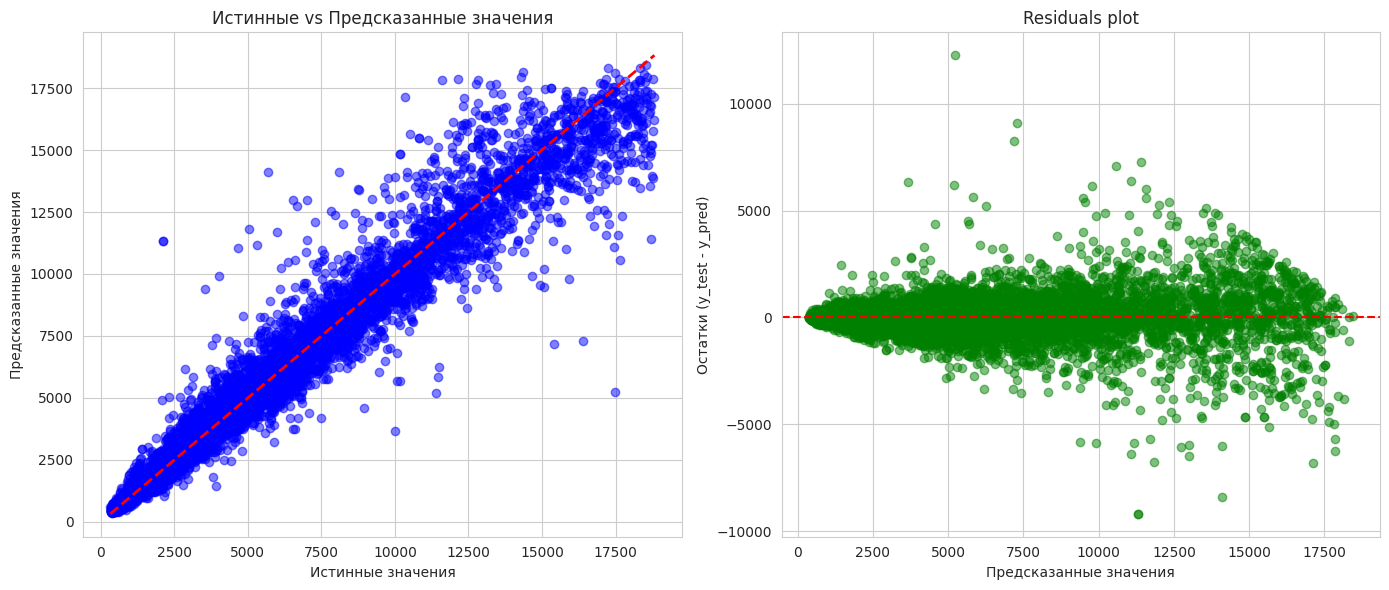

In [29]:
residuals = y_test - y_pred_knn

plt.figure(figsize=(14, 6))

# 1. Истинные vs Предсказанные значения
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_knn, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные значения')
plt.grid(True)

# 2. Остатки
plt.subplot(1, 2, 2)
plt.scatter(y_pred_knn, residuals, alpha=0.5, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки (y_test - y_pred)')
plt.title('Residuals plot')
plt.grid(True)

plt.tight_layout()
plt.show()

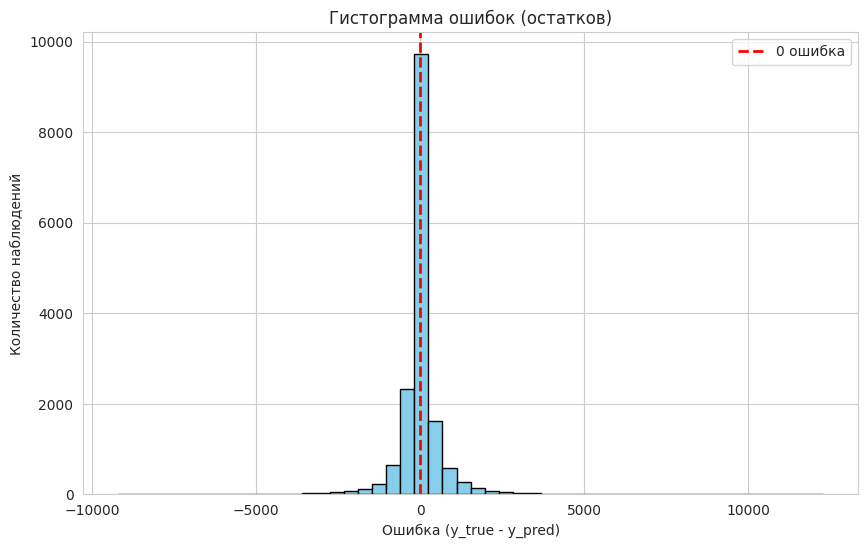

In [30]:
# Вычисляем ошибки (остатки)
residuals = y_test - y_pred_knn

# Гистограмма ошибок
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Гистограмма ошибок (остатков)")
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='0 ошибка')
plt.legend()
plt.show()

Графики в целом показывают то, о чем я писал выше. Модель показывает неплохие предсказания. Первые два графика показывают, что в целом уровень предсказаний точный, точки расположены около линии, но при более больших значениях они все же немножко рассеиваются от линии, по сравнению с более плотным распределением при низких ценах. Теперь попробуем еще улучшить предсказания модели.

# Выдвигаем гипотезы

## Гипотеза 1
Подбор гиперпараметров KNN (число соседей, метрика расстояния, способ взвешивания) с использованием кросс-валидации может заметно снизить ошибку модели.

## Гипотеза 2
Неравномерное распределение цены приводит к смещению модели в сторону дешёвых бриллиантов, поэтому взвешивание объектов или соседей с учётом редких ценовых диапазонов может улучшить качество предсказаний.

## Гипотеза 3
Использование альтернативных способов масштабирования признаков может уменьшить влияние выбросов и улучшить расчёт расстояний в KNN.

## Гипотеза 4
Обучение и оценка модели отдельно по ценовым диапазонам может повысить точность предсказаний внутри каждого сегмента.

In [31]:
# Гипотеза 1
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 15, 20, 25, 31],
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance']
}

gs = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)

print(f"R2:   {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")

results.append({
    "Модель": "KNN + гипотеза 1",
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred)
})


R2:   0.9691
RMSE: 694.2295
MAE:  342.7172


In [32]:
# Вывод лучших гиперпараметров
print("="*50)
print("Лучшие гиперпараметры KNN:")
print(gs.best_params_)
print("="*50)

Лучшие гиперпараметры KNN:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


In [33]:
# Гипотеза 2
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

knn_log = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(
        n_neighbors=5,
        metric='manhattan',
        weights='distance'
    ))
])

knn_log.fit(X_train, y_train_log)
y_pred_log = knn_log.predict(X_test)

y_pred = np.expm1(y_pred_log)

print(f"R2:   {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")

results.append({
    "Модель": "KNN + гипотеза 2",
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred)
})



R2:   0.9681
RMSE: 705.6548
MAE:  345.4571


In [34]:
# Гипотеза 3
from sklearn.preprocessing import RobustScaler

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

preprocessor_robust = ColumnTransformer([
    ('num', RobustScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

knn_robust = Pipeline([
    ('preprocessor', preprocessor_robust),
    ('knn', KNeighborsRegressor(
        n_neighbors=5,
        metric='manhattan',
        weights='distance'
    ))
])

knn_robust.fit(X_train, y_train)
y_pred = knn_robust.predict(X_test)

print(f"R2:   {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")

results.append({
    "Модель": "KNN + гипотеза 3",
    "R2": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred)
})


R2:   0.9758
RMSE: 613.8414
MAE:  289.8807


In [35]:
# Гипотеза 4
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

mask_train = y_train <= 5000
mask_test = y_test <= 5000

knn_segment = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(
        n_neighbors=5,
        metric='manhattan',
        weights='distance'
    ))
])

knn_segment.fit(X_train[mask_train], y_train[mask_train])
y_pred = knn_segment.predict(X_test[mask_test])

print(f"R2:   {r2_score(y_test[mask_test], y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test[mask_test], y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test[mask_test], y_pred):.4f}")

results.append({
    "Модель": "KNN + гипотеза 4",
    "R2": r2_score(y_test[mask_test], y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test[mask_test], y_pred)),
    "MAE": mean_absolute_error(y_test[mask_test], y_pred)
})



R2:   0.9658
RMSE: 245.5307
MAE:  157.4061


Сравнение моделей KNN


,Модель,R2,RMSE,MAE
0,Baseline KNN,0.9663,725.28,364.34
1,KNN + гипотеза 1,0.9691,694.23,342.72
2,KNN + гипотеза 2,0.9681,705.65,345.46
3,KNN + гипотеза 3,0.9758,613.84,289.88
4,KNN + гипотеза 4,0.9658,245.53,157.41


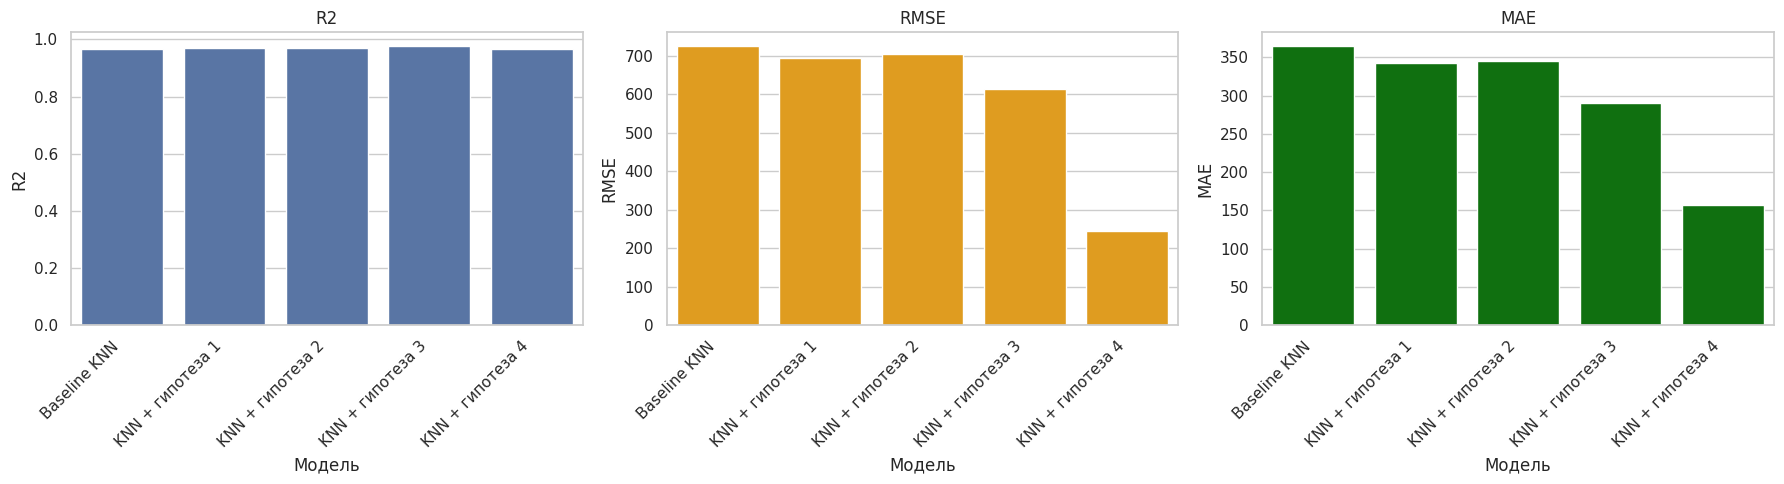

In [36]:
# Сравнение всех гипотез и стандартного бейзлайна
df_results = pd.DataFrame(results)

df_results['R2'] = df_results['R2'].round(4)
df_results['RMSE'] = df_results['RMSE'].round(2)
df_results['MAE'] = df_results['MAE'].round(2)

print("="*60)
print("Сравнение моделей KNN")
print("="*60)
display(df_results)  

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R2
sns.barplot(data=df_results, x='Модель', y='R2', ax=axes[0])
axes[0].set_title('R2')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# RMSE
sns.barplot(data=df_results, x='Модель', y='RMSE', ax=axes[1], color='orange')
axes[1].set_title('RMSE')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# MAE
sns.barplot(data=df_results, x='Модель', y='MAE', ax=axes[2], color='green')
axes[2].set_title('MAE')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

В отличие от задачи с классификацией, здесь гипотезы принесли реальную пользу. Как мы видим параметр R2 практически не меняется, однако последняя гипотеза дают невероятный прирост в RMSE и MAE, так же вторая дает ощутимый прирост. Думаю я соединю их вместе, а так же добавлю идеально подобранные гиперпараметры. Ето и будет мой улучшенный бейзлайн.


## Улучшенный бейзлайн

In [37]:
# Оптимальные гиперпараметры
knn_params = {'n_neighbors': 7, 'metric': 'manhattan', 'weights': 'distance'}

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

# Разделяем сегменты
segments = [(0, 5000), (5000, np.inf)]
predictions = np.zeros(len(y_test))

for seg_min, seg_max in segments:
    mask_train = (y_train >= seg_min) & (y_train < seg_max)
    mask_test = (y_test >= seg_min) & (y_test < seg_max)
    
    if mask_train.sum() == 0 or mask_test.sum() == 0:
        continue
    
    preprocessor = ColumnTransformer([
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
    
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('knn', KNeighborsRegressor(**knn_params))
    ])
    
    knn_pipeline.fit(X_train[mask_train], y_train[mask_train])
    predictions[mask_test] = knn_pipeline.predict(X_test[mask_test])

# Метрики
print("="*50)
print("Улучшенный бейзлайн KNN")
print("="*50)
print(f"R2:   {r2_score(y_test, predictions):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, predictions):.4f}")


# Сохраняем результаты
results.append({
    "Модель": "KNN улучшенный (3+4)",
    "R2": r2_score(y_test, predictions),
    "RMSE": np.sqrt(mean_squared_error(y_test, predictions)),
    "MAE": mean_absolute_error(y_test, predictions)
})

Улучшенный бейзлайн KNN
R2:   0.9838
RMSE: 502.4394
MAE:  247.0900


Мы видим интересный результат. Объединение гипотез 3 и 4 дало чуть более высокий R2 по сравнению со всеми остальными гипотезами, однако RMSE и MAE ухудшились по сравнению с гипотезой 4, хотя они лучше чем отдельно взятая гипотеза 3. Основная причина в том, что масштабирование признаков через RobustScaler слегка смягчает локальные различия внутри ценовых сегментов, которые гипотеза 4 использует максимально эффективно. В результате модель становится более стабильной на всём диапазоне данных, но теряет точность для сегментов с низкой дисперсией цен, что отражается в росте абсолютных ошибок. Поэтому, хотя R2 немного вырос, по практическим метрикам качества по сравнению с гипотезой 4 идет ухудшение и чистая гипотеза 4 остаётся более точной для этих сегментов.

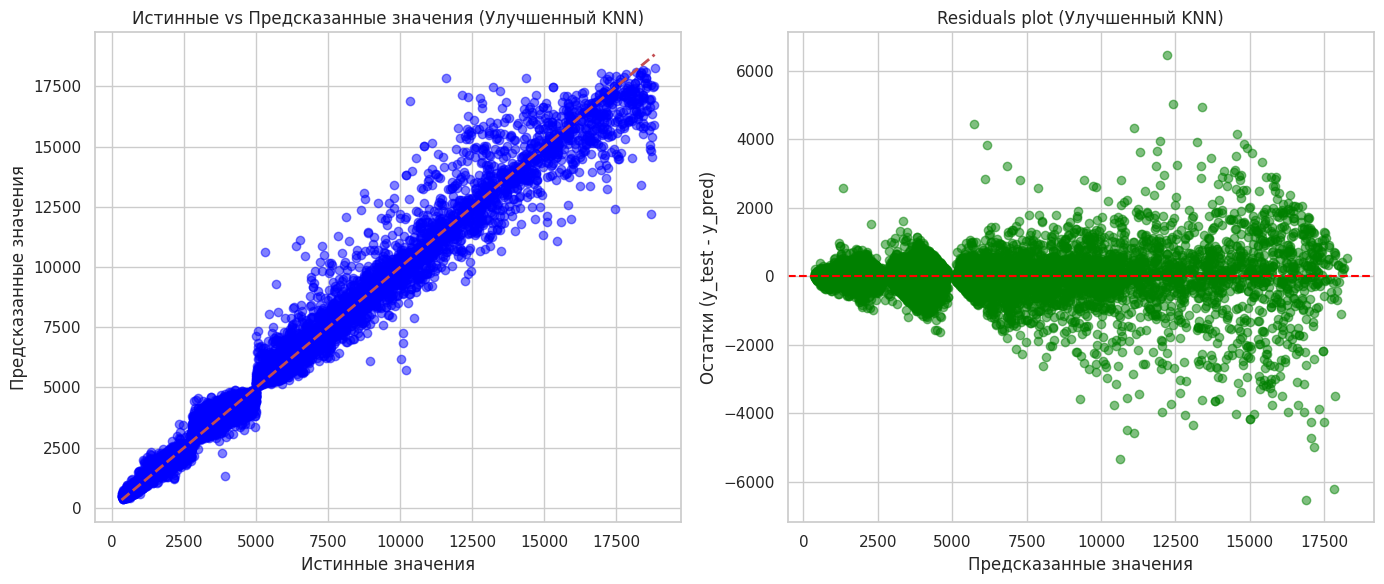

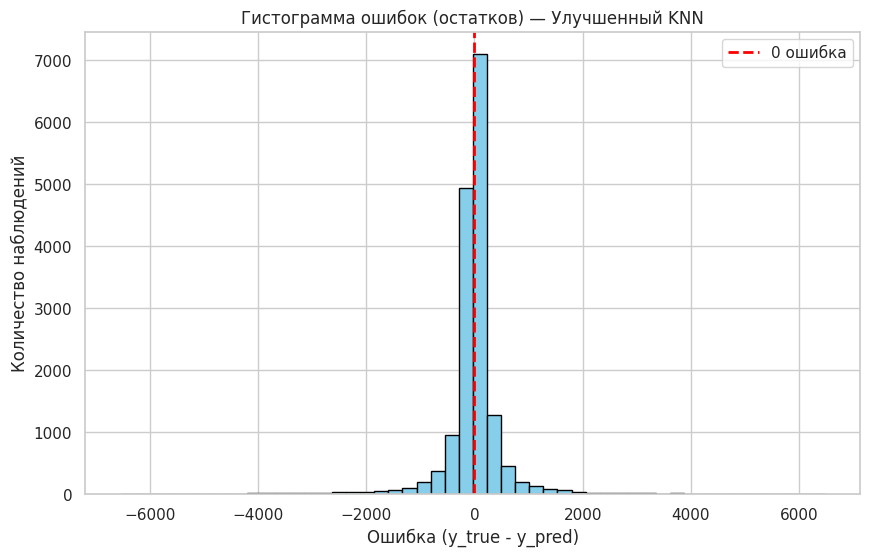

In [38]:
# Строим графики
residuals = y_test - predictions 

plt.figure(figsize=(14, 6))

# 1. Истинные vs Предсказанные значения
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные значения (Улучшенный KNN)')
plt.grid(True)

# 2. Остатки
plt.subplot(1, 2, 2)
plt.scatter(predictions, residuals, alpha=0.5, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки (y_test - y_pred)')
plt.title('Residuals plot (Улучшенный KNN)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Гистограмма ошибок (остатков)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Гистограмма ошибок (остатков) — Улучшенный KNN")
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='0 ошибка')
plt.legend()
plt.show()

Графики выглядят более "красиво", чем при обычном бейзлайне. В случае, когда брилиант стоит меньше 5000, точки стали еще более плотные, чем раньше, при более высоких ценах ситуация тоже улучшилась, точки менее разбросаны. Теперь напишем собственный KNN для регрессии

## Имплементация регрессии 


In [39]:
# Применяем препроцессор
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

class MyKNNRegressor:
    def __init__(self, n_neighbors=5, metric='manhattan'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X, dtype=np.float64)
        self.y_train = np.array(y, dtype=np.float64)

    def _distance(self, x, X):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((X - x) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(X - x), axis=1)
        else:
            raise ValueError("Метрика не поддерживается")

    def predict(self, X):
        X = np.array(X, dtype=np.float64)
        y_pred = []

        for x in X:
            distances = self._distance(x, self.X_train)
            idx_neighbors = np.argsort(distances)[:self.n_neighbors]
            neighbors_values = self.y_train[idx_neighbors]
            weights = 1 / (distances[idx_neighbors] + 1e-5)
            y_pred.append(np.sum(weights * neighbors_values) / np.sum(weights))

        return np.array(y_pred)

# ОБУЧЕНИЕ И ПРЕДСКАЗАНИЕ

knn_regressor = MyKNNRegressor(n_neighbors=5, metric='manhattan')
knn_regressor.fit(X_train_proc, y_train)
y_pred_knn = knn_regressor.predict(X_test_proc)

# МЕТРИКИ

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("="*50)
print("Имплементированный KNN регрессия")
print("="*50)
print(f"R2:   {r2_score(y_test, y_pred_knn):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_knn):.4f}")


Имплементированный KNN регрессия
R2:   0.9758
RMSE: 613.8418
MAE:  289.8815


In [40]:
results.append({
    "Модель": "Имплементированный KNN",
    "R2": r2_score(y_test, y_pred_knn),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_knn)),
    "MAE": mean_absolute_error(y_test, y_pred_knn)
})

df_results = pd.DataFrame(results)

df_comparison = pd.DataFrame([r for r in results if r["Модель"] in ["Baseline KNN", "Имплементированный KNN"]])

print("="*60)
print("Сравнение обычного и имплементированного KNN")
print("="*60)
print(df_comparison)

Сравнение обычного и имплементированного KNN
                   Модель        R2        RMSE         MAE
0            Baseline KNN  0.966271  725.280128  364.336436
1  Имплементированный KNN  0.975840  613.841751  289.881502


Как мы видим имплементированный KNN дает лучшие результаты по сравнению с обычным бейзлайном. И улучшения довольно значительные. Улучшение связано с тем, что в собственной реализации напрямую рассчитываются расстояния между объектами и учитываются веса соседей, что позволяет модели точнее обрабатывать выбросы и особенности данных. В результате предсказания становятся более стабильными и точным

## Имплементированный KNN + гипотезы 1 и 4

In [41]:
# Оптимальные гиперпараметры
n_neighbors = 7
metric = 'manhattan'

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

segments = [(0, 5000), (5000, np.inf)]
predictions = np.zeros(len(y_test))

class MyKNNRegressor:
    def __init__(self, n_neighbors=5, metric='manhattan'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X, dtype=np.float64)
        self.y_train = np.array(y, dtype=np.float64)

    def _distance(self, x, X):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((X - x) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(X - x), axis=1)
        else:
            raise ValueError("Метрика не поддерживается")

    def predict(self, X):
        X = np.array(X, dtype=np.float64)
        y_pred = []

        for x in X:
            distances = self._distance(x, self.X_train)
            idx_neighbors = np.argsort(distances)[:self.n_neighbors]
            neighbors_values = self.y_train[idx_neighbors]
            weights = 1 / (distances[idx_neighbors] + 1e-5)
            y_pred.append(np.sum(weights * neighbors_values) / np.sum(weights))

        return np.array(y_pred)


# ОБУЧЕНИЕ И ПРЕДСКАЗАНИЕ ПО СЕГМЕНТАМ
for seg_min, seg_max in segments:
    mask_train = (y_train >= seg_min) & (y_train < seg_max)
    mask_test = (y_test >= seg_min) & (y_test < seg_max)

    if mask_train.sum() == 0 or mask_test.sum() == 0:
        continue

    knn_segmented = MyKNNRegressor(n_neighbors=n_neighbors, metric=metric)
    knn_segmented.fit(X_train_proc[mask_train], y_train[mask_train])
    predictions[mask_test] = knn_segmented.predict(X_test_proc[mask_test])


# МЕТРИКИ
print("="*50)
print("Имплементированный KNN регрессия с сегментами по цене")
print("="*50)
print(f"R2:   {r2_score(y_test, predictions):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, predictions):.4f}")


# Сохраняем в результаты
results.append({
    "Модель": "Имплементированный KNN + гипотеза 4",
    "R2": r2_score(y_test, predictions),
    "RMSE": np.sqrt(mean_squared_error(y_test, predictions)),
    "MAE": mean_absolute_error(y_test, predictions)
})


Имплементированный KNN регрессия с сегментами по цене
R2:   0.9770
RMSE: 598.2782
MAE:  282.9026


И мы видим интересный результат. Имплементированный KNN лучше обычного, но при этом Имплементированный KNN с разбиением на два сегмента хуже обычного KNN с разбиением на два сегмента. Это происходит потому, что в нашей реализации в каждом ценовом сегменте меньше соседей для усреднения, что делает предсказания менее стабильными. Кроме того, простая имплементация хуже справляется с высокоразмерными и разреженными данными после масштабирования и one-hot кодирования, а также механизм взвешивания по обратной дистанции становится менее точным в маленьких сегментах, что увеличивает ошибки.

Сравнение всех моделей


,Модель,R2,RMSE,MAE
0,KNN улучшенный (3+4),0.983813,502.439373,247.090049
1,Имплементированный KNN + гипотеза 4,0.977049,598.278155,282.902617
2,KNN + гипотеза 3,0.975840,613.841379,289.880714
3,Имплементированный KNN,0.975840,613.841751,289.881502
4,KNN + гипотеза 1,0.969097,694.229540,342.717218
5,KNN + гипотеза 2,0.968072,705.654807,345.457093
6,Baseline KNN,0.966271,725.280128,364.336436
7,KNN + гипотеза 4,0.965818,245.530703,157.406109


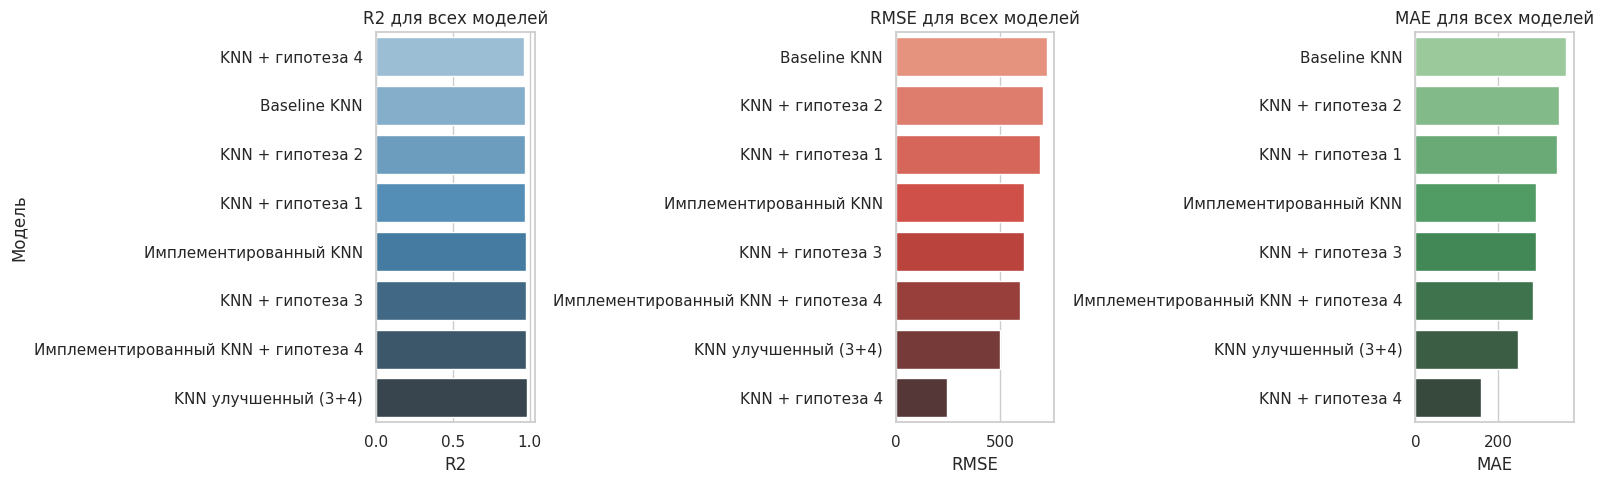

In [42]:
# Выведем все итоговые результаты регрессии в табличку и сделаем графики.
df_results = pd.DataFrame(results)

print("="*70)
print("Сравнение всех моделей")
print("="*70)
display(df_results.sort_values(by="R2", ascending=False).reset_index(drop=True))

sns.set(style="whitegrid")
plt.figure(figsize=(16, 5))

# График R2
plt.subplot(1, 3, 1)
sns.barplot(x="R2", y="Модель", data=df_results.sort_values("R2"), palette="Blues_d")
plt.title("R2 для всех моделей")
plt.xlabel("R2")
plt.ylabel("Модель")

# График RMSE
plt.subplot(1, 3, 2)
sns.barplot(x="RMSE", y="Модель", data=df_results.sort_values("RMSE", ascending=False), palette="Reds_d")
plt.title("RMSE для всех моделей")
plt.xlabel("RMSE")
plt.ylabel("")

# График MAE
plt.subplot(1, 3, 3)
sns.barplot(x="MAE", y="Модель", data=df_results.sort_values("MAE", ascending=False), palette="Greens_d")
plt.title("MAE для всех моделей")
plt.xlabel("MAE")
plt.ylabel("")

plt.tight_layout()
plt.show()

## Итоги регрессии 

Базовый KNN показывает достаточно высокую точность сам по себе. Настройка гиперпараметров (гипотеза 1) и попытка компенсировать редкие ценовые диапазоны (гипотеза 2) дают только небольшое улучшение ошибок.

Гипотеза 3 с альтернативным масштабированием признаков заметно снижает RMSE и MAE — модель становится более устойчива к выбросам, поэтому предсказания ближе к реальным значениям.

Гипотеза 4, где мы делим данные на сегменты по цене, отлично справляется внутри каждого сегмента: ошибки RMSE и MAE сильно падают для дешевых и дорогих бриллиантов.

Совмещеные гипотезы 3 и 4 дает более плохие результаты чем гипотеза 4, но она лучше гипотезы 3 взятой отдельно.

Наша собственная имплементация KNN без сегментации работает даже чуть лучше обычного KNN по глобальным метрикам ошибок, что подтверждает корректность реализации и эффективность взвешивания соседей. Однако когда мы применяем сегментацию к нашей реализации KNN (как в гипотезе 4), ошибки снова увеличиваются по сравнению с обычной KNN с сегментами. О причинах етого я рассуждал выше.